# intall kaggle

In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d werty12121/animal-mouse-vs-computer-mouse-text-dataset

  0% 0.00/8.40M [00:00<?, ?B/s]
100% 8.40M/8.40M [00:00<00:00, 115MB/s]


In [ ]:
! unzip animal-mouse-vs-computer-mouse-text-dataset.zip

# import libary

In [ ]:
import pandas as pd

In [ ]:
dfTextAnimal = pd.read_csv('/content/animal.csv')
dfTextAnimal['kelas'] = 'animal'
dfTextAnimal = dfTextAnimal[0:2000]
dfTextComputer = pd.read_csv('/content/computer.csv')
dfTextComputer['kelas'] = 'komputer'
dfTextComputer = dfTextComputer[0:2000]

In [ ]:
dfJoin = pd.concat([dfTextAnimal,dfTextComputer],ignore_index=True)
dfJoin.tail()

,text,kelas
3995,but use my pc on the sofa keyboard on knee cus...,komputer
3996,bit too often lose sight where the mouse went ...,komputer
3997,with wireless mouse might never find it again lol,komputer
3998,just picked one of these up used from ebay roc...,komputer
3999,so have ticket where want to rma my mouse they...,komputer


In [ ]:
dfBaru = dfJoin.drop(columns = ['kelas'])
dfBaru

,text
0,they can breed any time of the year their gest...
1,mouse the keystone cops of rodents
2,some species of the jerboa family have long ea...
3,they use quadrupedal locomotion but their larg...
4,armenian birch mouse
...,...
3995,but use my pc on the sofa keyboard on knee cus...
3996,bit too often lose sight where the mouse went ...
3997,with wireless mouse might never find it again lol
3998,just picked one of these up used from ebay roc...


In [ ]:
kategori = pd.get_dummies(dfJoin.kelas)
kategori

,animal,komputer
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
3995,0,1
3996,0,1
3997,0,1
3998,0,1


# Ubah ke list array


In [ ]:
import numpy as np

In [ ]:
sinopsis = dfJoin['text'].values
label = kategori[['animal','komputer']].values

# PreProcessing
menghilangkan tanda baca

In [ ]:
from nltk import RegexpTokenizer

In [ ]:
# Menghilangkan tanda baca
tokenizerTandaBaca = RegexpTokenizer(r"\w+")
sinopsisBaru = [tokenizerTandaBaca.tokenize(sinopsis[i]) for i in range(len(sinopsis))]

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def sWord(kalimat):
  return [w for w in kalimat if not w.lower() in stop_words]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
sinopsisBaru2 = [sWord(sinopsisBaru[i]) for i in range(len(sinopsisBaru))]

# Pisah jadi data latih dan data training

In [ ]:
from sklearn.model_selection import train_test_split
sinopsis_latih, sinopsis_test, label_latih, label_test = train_test_split(sinopsisBaru2, label, test_size=0.2,random_state=10)

# Precosesing
untuk data mempermudah dalam proses klasifikasi

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tokenizer = Tokenizer(num_words=8093, oov_token='-')
tokenizer.fit_on_texts(sinopsis_latih)

sekuens_latih = tokenizer.texts_to_sequences(sinopsis_latih)
sekuens_test = tokenizer.texts_to_sequences(sinopsis_test)

padded_latih = pad_sequences(sekuens_latih,
                             padding='post',
                             maxlen=256,
                             truncating='post') 
padded_test = pad_sequences(sekuens_test,
                            padding='post',
                            maxlen=256,
                            truncating='post')

In [ ]:
len(tokenizer.word_counts)

8093

# Masuk ke JST

In [ ]:
import tensorflow as tf

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=8093, output_dim=16,input_length = 256),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.summary() 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 256, 16)           129488    
                                                                 
 bidirectional_2 (Bidirectio  (None, 256, 128)         41472     
 nal)                                                            
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 2)                

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.98):
      self.model.stop_training = True
      print("\nAkurasi telah mencapai >90%!")
callbacks = myCallback()

In [ ]:
num_epochs = 30
history = model.fit(padded_latih, label_latih, epochs=num_epochs,
                    validation_data=(padded_test, label_test), verbose=2, callbacks = callbacks)

Epoch 1/30

Akurasi telah mencapai >90%!
100/100 - 21s - loss: 0.0401 - accuracy: 0.9887 - val_loss: 0.0960 - val_accuracy: 0.9675 - 21s/epoch - 206ms/step


# Membuat Plot

In [ ]:
import matplotlib.pyplot as plt

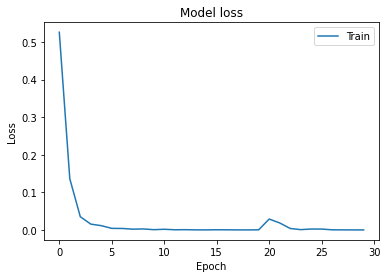

In [ ]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

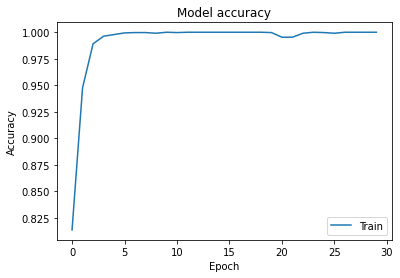

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()

In [ ]:
mySet = set([1,2,3,6,4,2,4,6,1])
mySet
myList = list(mySet)
myList

[1, 2, 3, 4, 6]